In [1]:
import os, os.path
import glob
import pickle
import numpy
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util_old as pal5_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot


Populating the interactive namespace from numpy and matplotlib


In [4]:
#define functions
def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)
                     

def compute_Pk(filename, scaling = 'spectrum'):
    data= numpy.loadtxt(filename)
    p1=data[:,0]
    tdata=data[:,1]
    data_err=data[:,2]
    
    px,py= signal.csd(tdata,tdata,fs=1./(p1[1]-p1[0]),scaling=scaling,nperseg=len(p1))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(p1[-1]-p1[0]))
    
            
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err= numpy.empty((nerrsim,len(px)))
    for ii in range(nerrsim):
        tmock= data_err*numpy.random.normal(size=len(p1))
        ppy_err[ii]= signal.csd(tmock,tmock,
                                fs=1./(p1[1]-p1[0]),scaling=scaling,
                                nperseg=len(p1))[1].real
    py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(p1[-1]-p1[0]))
    
    #return 180./px/numpy.pi, py, py_err #if apars
    return px, py, py_err




def set_ranges_and_labels_dens():
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
    ylim(0.0001,10.)
    xlim(1,150.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None





def process_sample(dir_trail,out_format='radec'):
    #dir_trail contains all the sample files from the trailing arm
    #convert R,z,phi to ra,dec to xi, eta
    dir_lead = dir_trail.replace('trailing','leading')
    allfname_trail= glob.glob(dir_trail + '*.dat')
    allfname_lead= glob.glob(dir_lead + '*.dat')
    R_t=[]
    phi_t=[]
    z_t=[]
    vR_t=[]
    vT_t=[]
    vz_t=[]
    t_t=[]

    R_l=[]
    phi_l=[]
    z_l=[]
    vR_l=[]
    vT_l=[]
    vz_l=[]
    t_l=[]
     
    for i in range(len(allfname_trail)):
        try :
            #for i in range(10):
            R_t.append(numpy.loadtxt(allfname_trail[i])[:,0])
            phi_t.append(numpy.loadtxt(allfname_trail[i])[:,1])
            z_t.append(numpy.loadtxt(allfname_trail[i])[:,2])
            vR_t.append(numpy.loadtxt(allfname_trail[i])[:,3])
            vT_t.append(numpy.loadtxt(allfname_trail[i])[:,4])
            vz_t.append(numpy.loadtxt(allfname_trail[i])[:,5])
            t_t.append(numpy.loadtxt(allfname_trail[i])[:,6])
            
        except ValueError:
            print (allfname_trail[i])
        
    for ii in range(len(allfname_lead)):
        try:
            #for ii in range(10):
            R_l.append(numpy.loadtxt(allfname_lead[ii])[:,0])
            phi_l.append(numpy.loadtxt(allfname_lead[ii])[:,1])
            z_l.append(numpy.loadtxt(allfname_lead[ii])[:,2])
            vR_l.append(numpy.loadtxt(allfname_lead[ii])[:,3])
            vT_l.append(numpy.loadtxt(allfname_lead[ii])[:,4])
            vz_l.append(numpy.loadtxt(allfname_lead[ii])[:,5])
            t_l.append(numpy.loadtxt(allfname_lead[ii])[:,6])
            
        except ValueError:
            print (allfname_lead[ii])
        
    Rall_t = np.array([item for sublist in R_t for item in sublist])
    phiall_t = np.array([item for sublist in phi_t for item in sublist])
    zall_t = np.array([item for sublist in z_t for item in sublist])
    vRall_t = np.array([item for sublist in vR_t for item in sublist])
    vTall_t = np.array([item for sublist in vT_t for item in sublist])
    vzall_t = np.array([item for sublist in vz_t for item in sublist])
    tall_t = np.array([item for sublist in t_t for item in sublist])

    Rall_l = np.array([item for sublist in R_l for item in sublist])
    phiall_l = np.array([item for sublist in phi_l for item in sublist])
    zall_l = np.array([item for sublist in z_l for item in sublist])
    vRall_l = np.array([item for sublist in vR_l for item in sublist])
    vTall_l = np.array([item for sublist in vT_l for item in sublist])
    vzall_l = np.array([item for sublist in vz_l for item in sublist])
    tall_l = np.array([item for sublist in t_l for item in sublist])
    
    x_l,y_l,z_l=bovy_coords.cyl_to_rect(Rall_l,phiall_l,zall_l)
    
    l_t,b_t,d_t=np.array(galcencyl_to_lbd(Rall_t,phiall_t,zall_t))
    l_l,b_l,d_l=np.array(galcencyl_to_lbd(Rall_l,phiall_l,zall_l))
    
    radec_t=bovy_coords.lb_to_radec(l_t,b_t,degree=True) 
    radec_l=bovy_coords.lb_to_radec(l_l,b_l,degree=True)
    
    o_t=[]
    ts_t=[]
    o_l=[]
    ts_l=[]
    
   
    if out_format=='radec' :
        return (radec_t[:,0],radec_t[:,1],radec_l[:,0],radec_l[:,1])
    
    elif out_format=='xieta':
        
        mxieta_t= pal5_util.radec_to_pal5xieta(radec_t[:,0],radec_t[:,1],degree=True)
        xi_t= mxieta_t[:,0]
        eta_t=mxieta_t[:,1]

        mxieta_l= pal5_util.radec_to_pal5xieta(radec_l[:,0],radec_l[:,1],degree=True)
        xi_l= mxieta_l[:,0]
        eta_l=mxieta_l[:,1]
    
        return (xi_t,eta_t,xi_l,eta_l)
        
        
    else : 
        print ("acceptable output format : radec or xieta")
        

def compute_ndenxi(xi,minxi=0.25,maxxi=14.35,bw=0.1,polydeg=3,plot=True,label='',fname=''):
    N=len(xi)
    print (N)
    minxi = minxi
    maxxi= maxxi
    bw= bw

    nbins= (maxxi - minxi)/bw
    print ("no of xi bins = %i"%nbins)

    xibin_edge=[(minxi-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    #print (xibin_edge)
    midxi=[0.5*(xibin_edge[i] + xibin_edge[i+1]) for i in range(int(nbins)+1)]
    
    nden=np.histogram(xi,xibin_edge,density=True)[0]
    Ndn=np.histogram(xi,xibin_edge)[0]
    print (np.sum(Ndn))
    shot_noise=numpy.sqrt(Ndn)
    err=shot_noise/(N*bw)
    
    pp= Polynomial.fit(midxi,Ndn,deg=polydeg,w=1/shot_noise)
    nden=Ndn/pp(np.array(midxi))
    den_err=np.sqrt(Ndn)/pp(np.array(midxi))
        
    if plot :
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            plt.plot(midxi,Ndn,ls='steps-mid',label=label)
            plt.errorbar(midxi,Ndn,shot_noise,marker='None',ls='None')
            plt.plot(midxi,pp(np.array(midxi)),c='r',label=r'$3^{\rm{rd}}$ order polynomial')
            plt.xlabel(r'$\xi$ (deg)',fontsize=18)
            plt.ylabel('Star count',fontsize=18)
            plt.legend(loc='upper right',fontsize=18)
    
            plt.subplot(1,2,2)
            plt.plot(midxi,nden,ls='steps-mid')
            plt.errorbar(midxi,nden,den_err,marker='None',ls='None')
            plt.errorbar(midxi,nden,marker='None',ls='None')
            plt.xlabel(r'$\xi$ (deg)',fontsize=18)
            plt.ylabel('normalized star count',fontsize=18)
            
            if fname != '' :
                plt.savefig(fname)
            
            plt.show()
            
    return (midxi,nden,den_err,Ndn)

def include_both_arms(xi_t,eta_t,xi_l,eta_l):
    min_eta_t=min(eta_t)
    max_eta_t=max(eta_t)

    xi_l_select=[]
    eta_l_select=[]

    for jj in range(len(eta_l)):
        if min_eta_t <= eta_l[jj] <= max_eta_t :
            xi_l_select.append(xi_l[jj])
            eta_l_select.append(eta_l[jj])

    print (len(xi_l), len(xi_l_select))

    plt.figure()
    plt.scatter(xi_l_select,eta_l_select)
    plt.show()
    
    xi_all = np.concatenate((xi_t,xi_l_select))
    
    return xi_all


  

### smooth (nobarpot)

10000 8084


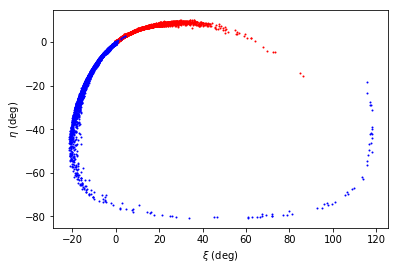

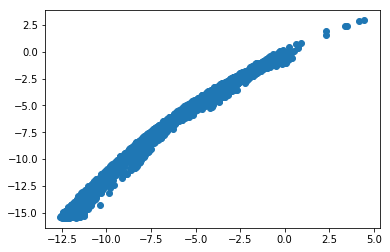

18084
no of xi bins = 141
7904


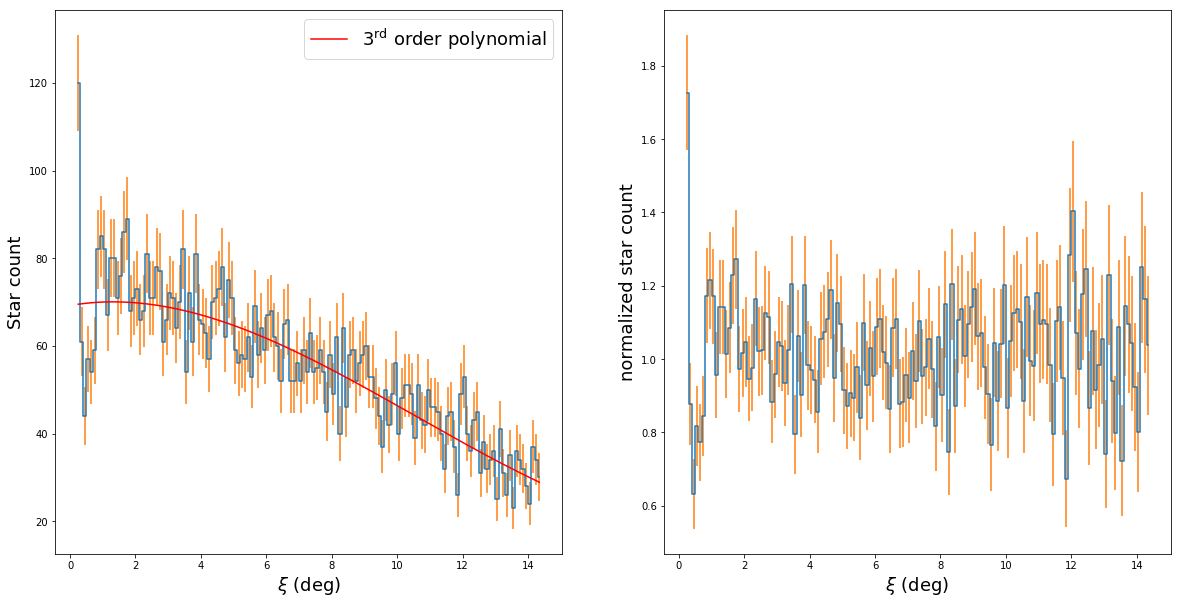

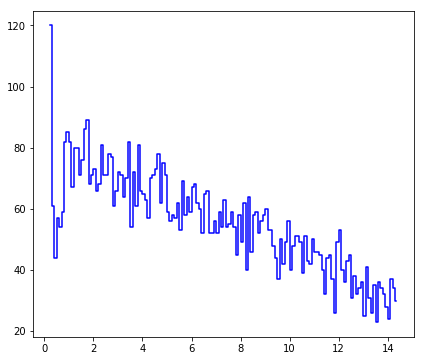

In [9]:
dir='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/500k_samples/1010Msun_streamdf_nobarpot/trailing/'
xi_t,eta_t,xi_l,eta_l=process_sample(dir,out_format='xieta')

plt.figure()
plt.scatter(xi_t,eta_t,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l,eta_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
#plt.legend(loc='upper right')
#plt.savefig('plots/revisit_barred_pal5.pdf')

xi_both_arms=include_both_arms(xi_t,eta_t,xi_l,eta_l)
smidxi,snden,serr,sNdn = compute_ndenxi(xi_both_arms,minxi=0.25,maxxi=14.35,bw=0.1,fname='')

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(smidxi,sNdn,ls='steps-mid',label='smooth',color='b')
#plt.savefig('plots/nden_spray_barpot45_smooth_dens_norm.pdf')
plt.show()

## Perturbed stream

/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_39patspeed_streamdf/trailing/sample1000_extra1_streamdf_trailing_1010Msun_5Gyr_patspeed39_739.dat
/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_39patspeed_streamdf/trailing/sample1000_extra_streamdf_trailing_1010Msun_5Gyr_patspeed39_1039.dat
/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_39patspeed_streamdf/trailing/sample1000_extra_streamdf_trailing_1010Msun_5Gyr_patspeed39_1139.dat
/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_39patspeed_streamdf/trailing/sample1000_extra_streamdf_trailing_1010Msun_5Gyr_patspeed39_1339.dat
/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_39patspeed_streamdf/trailing/sample1000_extra_streamdf_trailing_1010Msun_5Gyr_patspeed39_1539.dat
/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_39patspeed_streamdf/trailing/sample1000_extra_streamdf_trailing_1010Msun_5Gyr_patspeed39_1739.dat
/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun

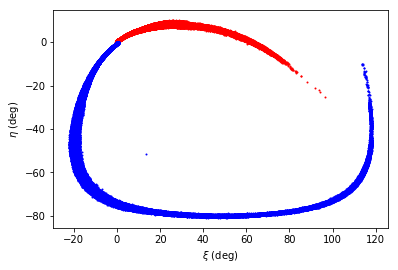

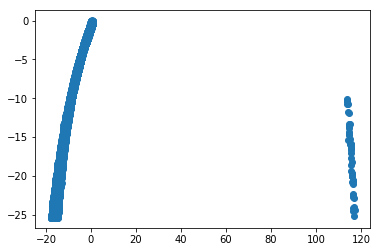

9246702
no of xi bins = 141
3025922


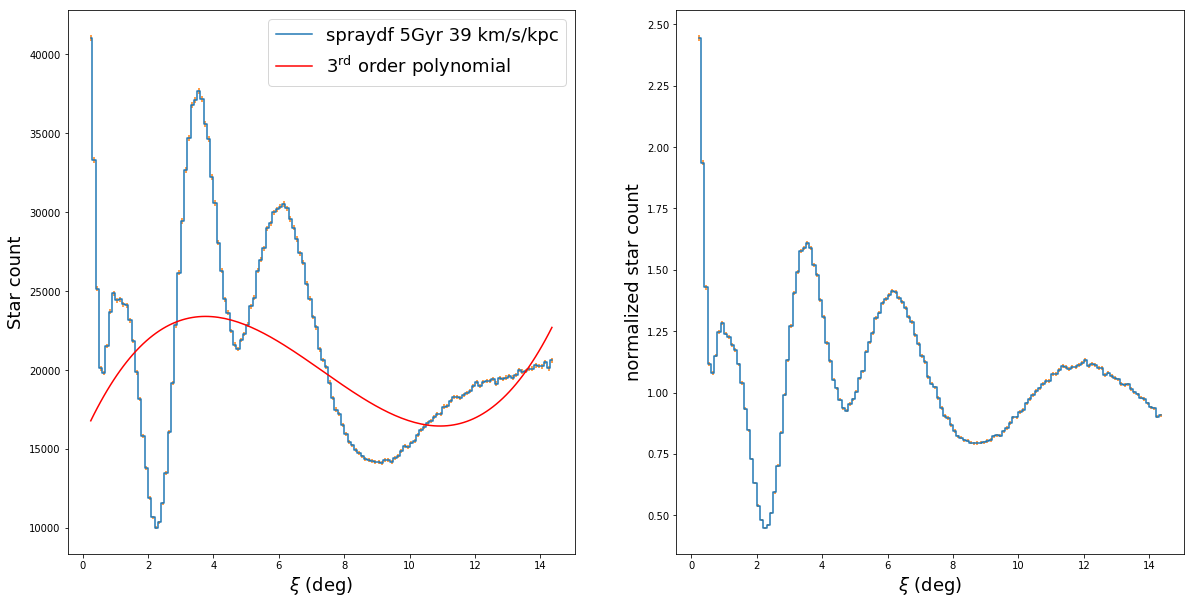

In [5]:
dir='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_39patspeed_streamdf/trailing/'
xi_t,eta_t,xi_l,eta_l=process_sample(dir,out_format='xieta')

plt.figure()
plt.scatter(xi_t,eta_t,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l,eta_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(-2.0,17.)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
#plt.legend(loc='upper right')
#plt.savefig('plots/spraydf_5Gyrbar_noprog_45patspeed.pdf')

xi_both_arms=include_both_arms(xi_t,eta_t,xi_l,eta_l)
midxi,nden,_,Ndn = compute_ndenxi(xi_both_arms,minxi=0.25,maxxi=14.35,bw=0.1,label='spraydf 5Gyr 39 km/s/kpc',
                                    fname='plots/nden_spraydf_5Gyr_patspeed39.pdf')

5132501 4113702


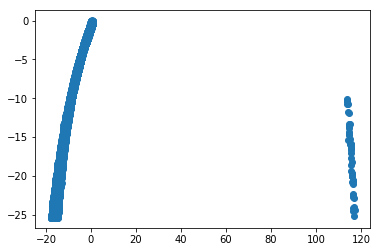

9246702
no of xi bins = 141
3025922


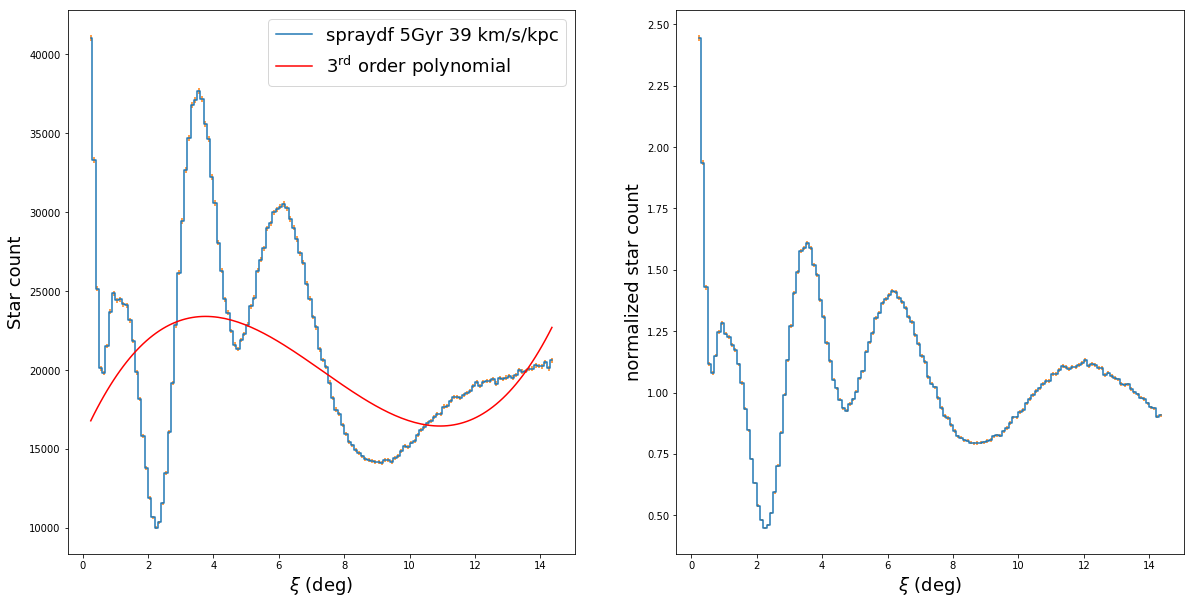

In [6]:
xi_both_arms=include_both_arms(xi_t,eta_t,xi_l,eta_l)
midxi,nden,nden_err,Ndn = compute_ndenxi(xi_both_arms,minxi=0.25,maxxi=14.35,bw=0.1,label='streamdf 5Gyr 39 km/s/kpc',
                                    fname='plots/nden_spraydf_5Gyr_patspeed39.pdf')

outdir1= '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_39patspeed_streamdf/'
fo_all1=open(outdir1 + 'Pal5_5M_density_botharms_streamdf_5Gyr_39patspeed.dat','w')
fo_all1.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden)):
    fo_all1.write(str(midxi[jj]) + "   " + str(nden[jj]) + "   " + str(nden_err[jj]) + "\n")
    
fo_all1.close()

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide



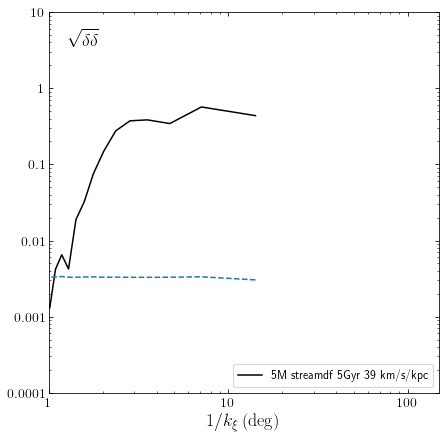

In [8]:
dir2='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'
fname=dir2 + '1010Msun_39patspeed_streamdf/Pal5_5M_density_botharms_streamdf_5Gyr_39patspeed.dat'

px,py,pyerr=compute_Pk(fname, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)
#$\Omega_{b} = 40$\ km/s/kpc \rm{2 Gyr bar grow}, Mbar = $10^{10} \ \rm{M}_{\odot}$
loglog(px,py,color='k',zorder=1,label=r'5M streamdf 5Gyr 39 km/s/kpc')
loglog(px,pyerr,ls='--',)
legend(loc='lower right')

set_ranges_and_labels_dens()
savefig('plots/power_5M_streamdf_39patspeed_5Gyr.pdf')

In [134]:
def compute_length(Ndn,sNdn,max_midxi=3.,minxi=0.25,maxxi=14.35,bw=0.1,frac=0.2,fname=''):
    
    nbins= (maxxi - minxi)/bw
    print ("no of xi bins = %i"%nbins)
    xibin_edge=[(minxi-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    #print (xibin_edge)
    midxi=[0.5*(xibin_edge[i] + xibin_edge[i+1]) for i in range(int(nbins)+1)]
    
    sNdn_select = []
    for jj in range(len(midxi)):
        if midxi[jj] < max_midxi :
            sNdn_select.append(sNdn[jj])
        
    sNdn_select=np.array(sNdn_select)
    mean_Ndn=np.mean(sNdn_select)

    ind=[]
    for ii in range(len(midxi)):
        #print (Ndn[ii],0.2*sNdn[ii])
        if Ndn[ii]<= mean_Ndn*frac:
            
            ind.append(ii)
    
    if len(ind) != 0 :
        maxxi=midxi[min(ind)]
    
    return maxxi-minxi



In [136]:
print (compute_length(Ndn=sNdn,sNdn=sNdn,max_midxi=3.))

no of xi bins = 141
14.1


### streamdf, include both arms.

101000 100991


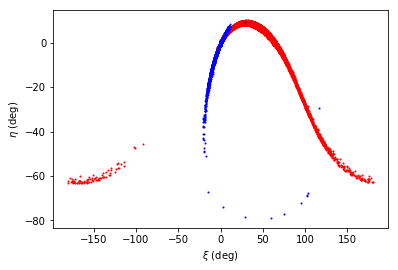

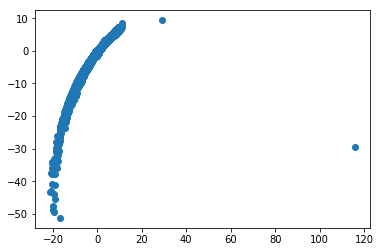

201991
no of xi bins = 141
101947


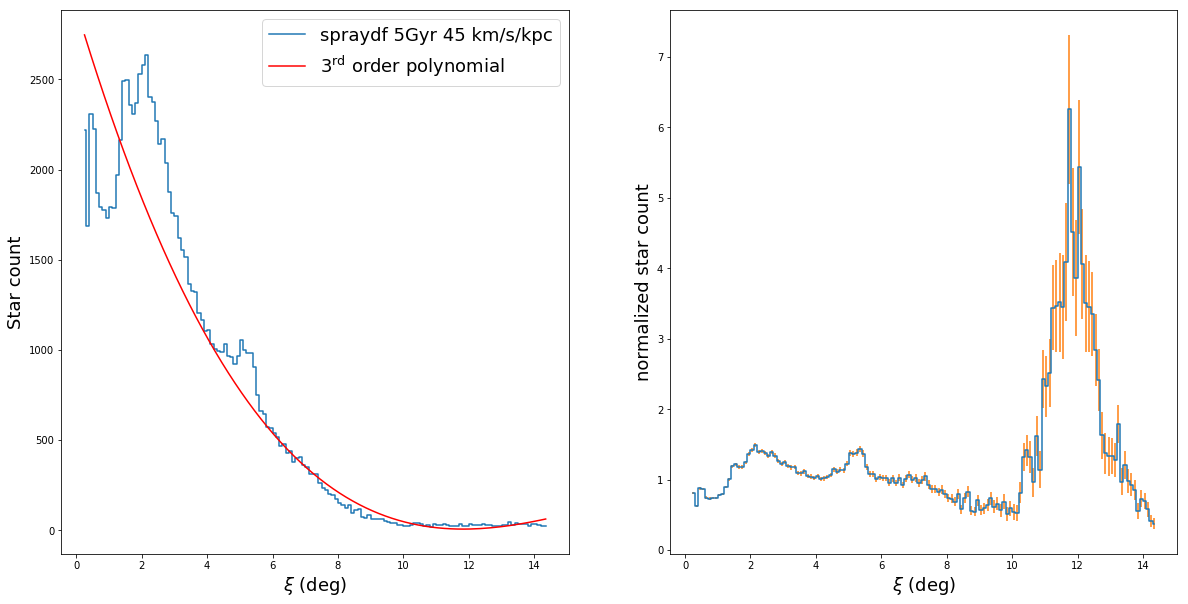

In [115]:
dir='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_5Gyr_spraydf_patspeed45/trailing/'
xi_t,eta_t,xi_l,eta_l=process_sample(dir,out_format='xieta')

plt.figure()
plt.scatter(xi_t,eta_t,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l,eta_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(-2.0,17.)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
#plt.legend(loc='upper right')
#plt.savefig('plots/spraydf_5Gyrbar_noprog_45patspeed.pdf')

xi_both_arms=include_both_arms(xi_t,eta_t,xi_l,eta_l)
midxi,nden,_,Ndn = compute_ndenxi(xi_both_arms,minxi=0.25,maxxi=14.35,bw=0.1,label='spraydf 5Gyr 45 km/s/kpc',
                                    fname='plots/nden_spraydf_5Gyr_patspeed45.pdf')

101000 96125


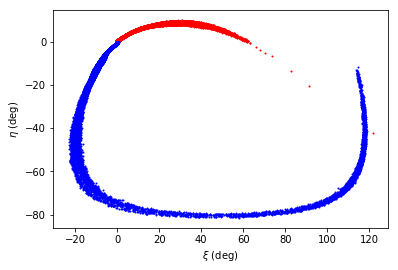

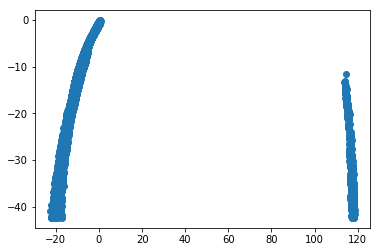

197125
no of xi bins = 141
61824


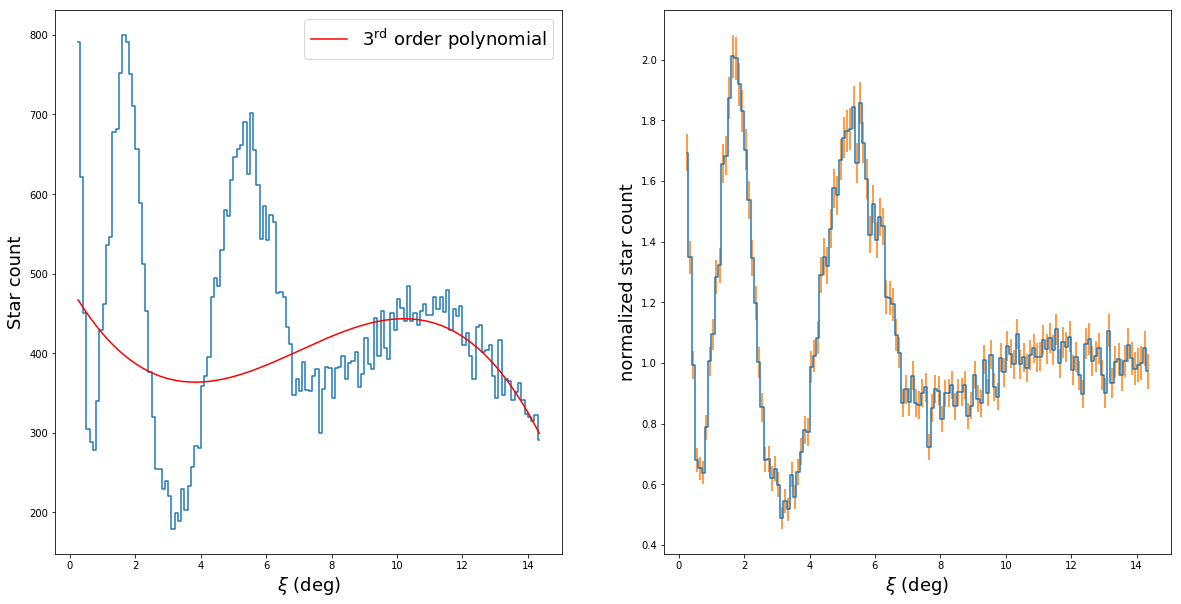

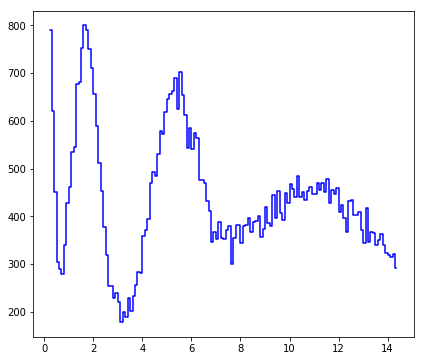

In [35]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(midxi,Ndn,ls='steps-mid',label='smooth',color='b')
#plt.savefig('plots/nden_spray_barpot45_smooth_dens_norm.pdf')
plt.show()

In [104]:
def compute_length(sNdn,Ndn,minxi=0.25,maxxi=14.35,bw=0.1,fname=''):
    minxi = minxi
    maxxi= maxxi
    bw= bw

    nbins= (maxxi - minxi)/bw
    print ("no of xi bins = %i"%nbins)

    xibin_edge=[(minxi-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    #print (xibin_edge)
    midxi=[0.5*(xibin_edge[i] + xibin_edge[i+1]) for i in range(int(nbins)+1)]
    ind=[]
    for ii in range(len(midxi)):
        #print (Ndn[ii],0.2*sNdn[ii])
        if Ndn[ii]<= 0.2*sNdn[ii]:
            
            ind.append(ii)
    
    if len(ind) != 0 :
        maxxi=midxi[min(ind)]
    
    return maxxi-minxi
            

In [111]:
print (compute_length(sNdn,Ndn))

no of xi bins = 141
3.1000000000000005


In [30]:
aa=[]
print (len(aa))

0


In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('45 km/s/kpc 5 Gyr spraydf')
plt.plot(midxi_all,Ndn_all,ls='steps-mid',label='smooth',color='r')
plt.plot(smidxi_all,sNdn_all,ls='steps-mid')
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.title('45 km/s/kpc 5 Gyr spraydf')
plt.plot(smidxi_all,sNdn_all/Ndn_all,ls='steps-mid')
plt.savefig('plots/nden_spray_barpot45_smooth_dens_norm.pdf')
plt.show()

In [ ]:
outdir1= '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed55_noprog_5Gyr_spraydf/'
fo_all1=open(outdir1 + 'Pal5_density_botharms_spraydf_5Gyr_55patspeed_smoothdensnorm.dat','w')
fo_all1.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(snden_all)):
    fo_all1.write(str(smidxi_all[jj]) + "   " + str(snden_all[jj]) + "   " + str(serr_all[jj]) + "\n")
    
fo_all1.close()

In [ ]:
dir2='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'
fname=dir2 + '1010Msun_patspeed35_noprog_5Gyr_spraydf/Pal5_density_botharms_spraydf_5Gyr_35patspeed_smoothdennorm.dat'
filename0=dir2 + '1010Msun_patspeed40_noprog_5Gyr_spraydf/Pal5_density_botharms_spraydf_5Gyr_40patspeed_poly3norm.dat'
filename1=dir2 + '1010Msun_patspeed45_noprog_5Gyr_spraydf/Pal5_density_botharms_spraydf_5Gyr_45patspeed_denssmoothnorm.dat'
filename2=dir2 + '1010Msun_patspeed50_noprog_5Gyr_spraydf/Pal5_density_botharms_spraydf_5Gyr_50patspeed_poly3norm.dat'
filename3=dir2 + '1010Msun_patspeed55_noprog_5Gyr_spraydf/Pal5_density_botharms_spraydf_5Gyr_55patspeed_smoothdensnorm.dat'

px,py,pyerr=compute_Pk(fname, scaling = 'spectrum')
px0,py0,pyerr=compute_Pk(filename0, scaling = 'spectrum')
px1,py1,pyerr=compute_Pk(filename1, scaling = 'spectrum')
px2,py2,pyerr=compute_Pk(filename2, scaling = 'spectrum')
px3,py3,pyerr=compute_Pk(filename3, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)
#$\Omega_{b} = 40$\ km/s/kpc \rm{2 Gyr bar grow}, Mbar = $10^{10} \ \rm{M}_{\odot}$
loglog(px,py,color='k',zorder=1,label=r'spraydf botharms 5Gyr 35 km/s/kpc smooth dens')
loglog(px0,py0,color='g',zorder=1,label=r'spraydf botharms 5Gyr 40 km/s/kpc poly3norm')
loglog(px1,py1,color='r',zorder=1,label=r'spraydf botharms 5Gyr 45 km/s/kpc smooth dens')
loglog(px2,py2,color='b',zorder=1,label=r'spraydf botharms 5Gyr 50 km/s/kpc poly3norm')
loglog(px3,py3,color='orange',zorder=1,label=r'spraydf botharms 5Gyr 55 km/s/kpc smooth dens')
#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right')

set_ranges_and_labels_dens()
savefig('plots/power_spraydf_noprog_5Gyrbarpot.pdf')

In [ ]:
dir1='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed40_noprog_5Gyr_streamdf/trailing/'
xi_t,eta_t,xi_l,eta_l=process_sample(dir1,out_format='xieta')

In [ ]:
#smidxi,snden,serr,sNdn=compute_ndenxi(sxi_t,minxi=0.25,maxxi=14.35,bw=0.1,polydeg=3,fname='')
midxi,nden,err,Ndn=compute_ndenxi(sxi_t,minxi=0.25,maxxi=14.35,bw=0.1,polydeg=3,fname='plots/nden_streamdf_noprog_5Gyr_35patspeed.pdf')

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('-40 km/s/kpc 5 Gyr')
plt.plot(midxi,Ndn,ls='steps-mid')
plt.plot(smidxi,sNdn,ls='steps-mid',color='r',label='smooth')
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.title('-40 km/s/kpc 5 Gyr')
plt.plot(smidxi,Ndn/sNdn,ls='steps-mid')
plt.savefig('plots/nden_spray_barpot-40_smooth_dens_norm.pdf')
plt.show()

In [ ]:
#write the mean density

outdir = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed40_5Gyr_particle_spray/'
fo=open(outdir + 'Pal5_density_spraydf_5Gyr_40patspeed_poly3norm.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(midxi)):
    fo.write(str(midxi[j]) + "   " + str(nden[j]) + "   " + str(err[j]) + "\n")
    
fo.close()

In [ ]:
dir='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed-40_5Gyr_particle_spray/trailing/'

ra_t, dec_t,ra_l,dec_l=process_sample(dir,out_format='radec')
xi_t,eta_t,xi_l,eta_l=process_sample(dir,out_format='xieta')


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t,dec_t,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l,dec_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(200,360)
#plt.ylim(-85,20)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'5 Gyr SCF bar, -40 km/s/kpc')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t,eta_t,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l,eta_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(-25,100)
#plt.ylim(-85,20)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'5 Gyr SCF bar, -40 km/s/kpc')
plt.legend(loc='upper right')

plt.savefig('plots/particlespray_5Gyrbarpot_-40patspeed_skycoords.pdf',format='pdf',dpi=100)
plt.show()



In [ ]:
#compute density along xi and save 

midxi,nden,err = compute_ndenxi(xi_t,minxi=0.25,maxxi=14.35,bw=0.1,polydeg=3,fname='plots/nden_spray_barpot_5Gyr_patspeed-40.pdf')

In [ ]:
#write the mean density

outdir = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_diffsigkvec_patspeed40_5Gyr_particle_spray/'
fo=open(outdir + 'Pal5_density_barot_particle_spray_bw0p1_polyfit3_trailing_5Gyr_1010Msun_40patspeed_diffsigkvec.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden)):
    fo.write(str(midxi[j]) + "   " + str(nden[j]) + "   " + str(err[j]) + "\n")
    
fo.close()

In [ ]:
outdir='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'


filename=outdir + '1010Msun_patspeed-40_5Gyr_particle_spray/Pal5_density_barot_particle_spray_bw0p1_polyfit3_trailing_5Gyr_1010Msun_-40patspeed.dat'
filename1=outdir + '1010Msun_diffsigkvec_patspeed40_5Gyr_particle_spray/Pal5_density_barot_particle_spray_bw0p1_polyfit3_trailing_5Gyr_1010Msun_40patspeed_diffsigkvec.dat'
filename2=outdir + '1010Msun_patspeed45_5Gyr_particle_spray/Pal5_density_particle_spray_samples_polyfit3_both_arms_SCFbarMbar1010_5Gyr_patspeed45.dat'
filename3=outdir + '1010Msun_patspeed50_5Gyr_particle_spray/Pal5_density_particle_spray_samples_polyfit3_both_arms_SCFbarMbar1010_5Gyr_patspeed50.dat'

px,py,pyerr=compute_Pk(filename, scaling = 'spectrum')
px1,py1,pyerr1=compute_Pk(filename1, scaling = 'spectrum')
px2,py2,pyerr2=compute_Pk(filename2, scaling = 'spectrum')
px3,py3,pyerr3=compute_Pk(filename3, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)
#$\Omega_{b} = 40$\ km/s/kpc \rm{2 Gyr bar grow}, Mbar = $10^{10} \ \rm{M}_{\odot}$
loglog(px,py,color='k',zorder=1,label=r'spray 5Gyr -40 km/s/kpc')
loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')

loglog(px1,py1,color='b',zorder=1,label=r'spray diffsigkvec 5Gyr 40 km/s/kpc')
loglog(px1,pyerr1,lw=2.,color='b',zorder=1,ls='--')

loglog(px2,py2,color='g',zorder=1,ls='-',label=r'spray 5Gyr 45 km/s/kpc')
loglog(px2,pyerr2,lw=2.,color='g',zorder=1,ls='--')

loglog(px3,py3,color='orange',zorder=1,ls='-',label=r'spray 5 Gyr 50 km/s/kpc')
loglog(px3,pyerr3,lw=2.,color='orange',zorder=1,ls='--')

set_ranges_and_labels_dens()
legend(loc='upper right')
savefig('plots/power_spray_5Gyrbarpot.pdf')





# Spiral arms : N=4, $\Omega = 19.5$ km/s/kpc, 1%

5008000 10892


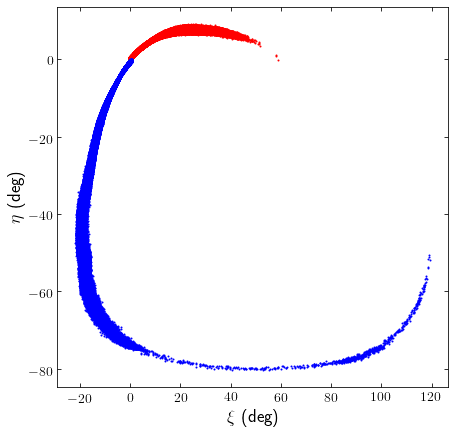

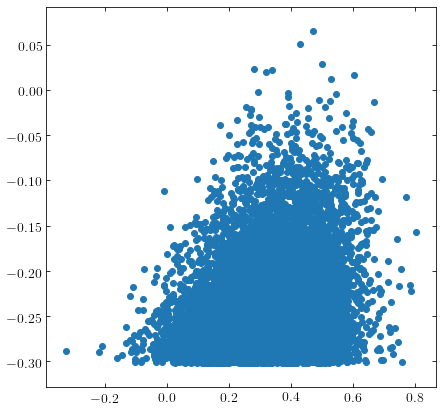

5018892
no of xi bins = 141
3406303


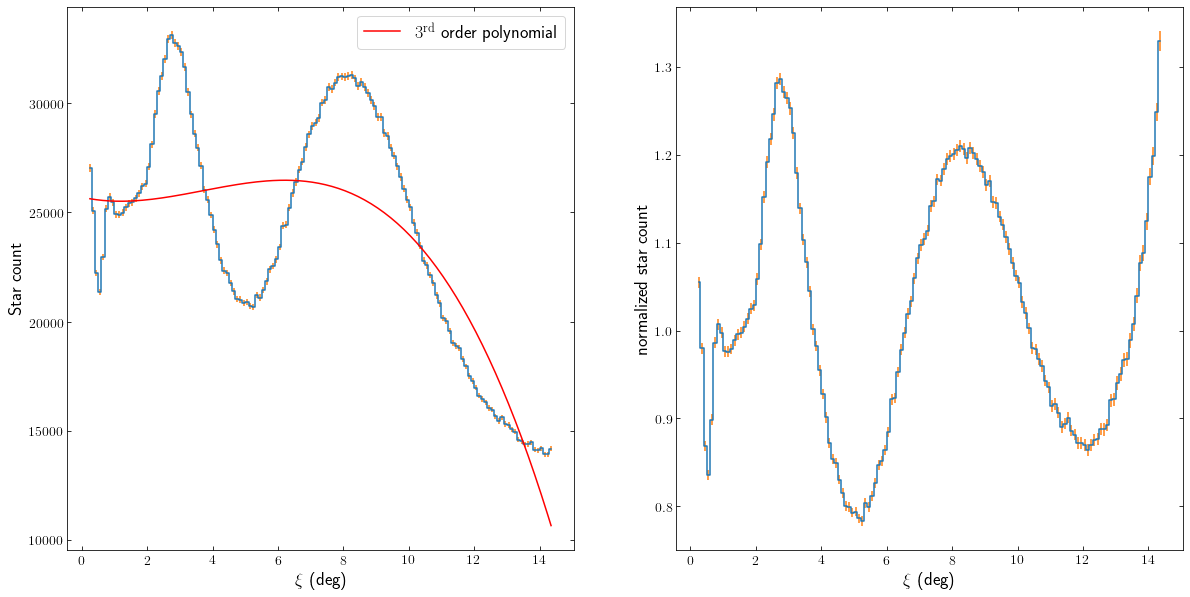

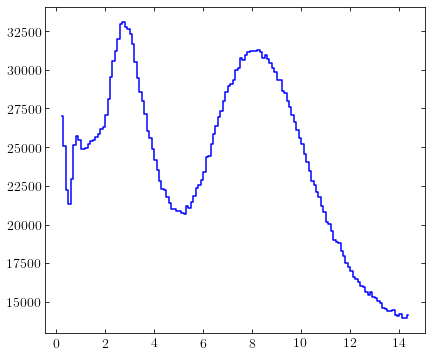

In [9]:
dir_spiral='/home/nil/Dropbox/streamgap-pepper/sampled_spiral/spiralN4_19.5patspeed_FR1.0_3Gyr_streamdf/trailing/'

xi_t,eta_t,xi_l,eta_l=process_sample(dir_spiral,out_format='xieta')

plt.figure()
plt.scatter(xi_t,eta_t,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l,eta_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
#plt.legend(loc='upper right')
#plt.savefig('plots/revisit_barred_pal5.pdf')

xi_both_arms=include_both_arms(xi_t,eta_t,xi_l,eta_l)
midxi,nden,nden_err,Ndn = compute_ndenxi(xi_both_arms,minxi=0.25,maxxi=14.35,bw=0.1,fname='')

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(midxi,Ndn,ls='steps-mid',label='smooth',color='b')
#plt.savefig('plots/nden_spiral_streamdf_5Gyr_N4_24p5patternspeed_1percent.pdf')
plt.show()

outdir = '/home/nil/Dropbox/streamgap-pepper/sampled_spiral/spiralN4_19.5patspeed_FR1.0_3Gyr_streamdf/'
fo=open(outdir + 'Pal5_density_botharms_spiralN4_19.5patspeed_FR1.0_3Gyr_streamdf_poly3norm.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden)):
    fo.write(str(midxi[j]) + "   " + str(nden[j]) + "   " + str(nden_err[j]) + "\n")
    
fo.close()



/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide



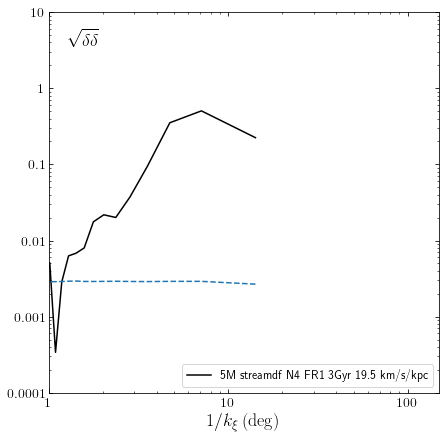

In [11]:
dir2='/home/nil/Dropbox/streamgap-pepper/sampled_spiral/spiralN4_19.5patspeed_FR1.0_3Gyr_streamdf/'
fname=dir2 + 'Pal5_density_botharms_spiralN4_19.5patspeed_FR1.0_3Gyr_streamdf_poly3norm.dat'

px,py,pyerr=compute_Pk(fname, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)
#$\Omega_{b} = 40$\ km/s/kpc \rm{2 Gyr bar grow}, Mbar = $10^{10} \ \rm{M}_{\odot}$
loglog(px,py,color='k',zorder=1,label=r'5M streamdf N4 FR1 3Gyr 19.5 km/s/kpc')
loglog(px,pyerr,ls='--',)
legend(loc='lower right')

set_ranges_and_labels_dens()
savefig('plots/power_5M_spiral_N4streamdf_FR1_19p5patspeed_3Gyr.pdf')

In [31]:
#write the mean density

outdir = '/home/nil/Dropbox/streamgap-pepper/sampled_spiral/spiralN4_24patspeed_FR1.0_2Gyr_spraydf/'
fo=open(outdir + 'Pal5_density_spraydf_spiral_N4_1percent_2Gyr_patspeed24.5_botharms.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden)):
    fo.write(str(midxi[j]) + "   " + str(nden[j]) + "   " + str(err[j]) + "\n")
    
fo.close()

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide



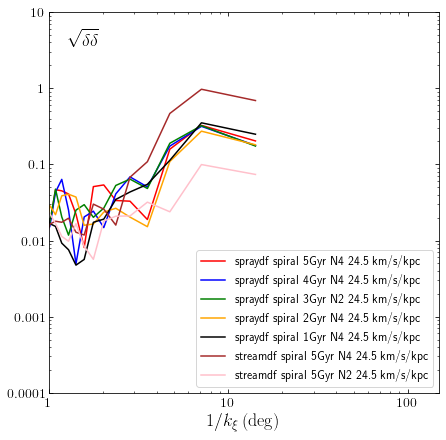

In [35]:
outdir='/home/nil/Dropbox/streamgap-pepper/sampled_spiral/'



filename1=outdir + 'spiralN4_24patspeed_FR1.0_5Gyr_spraydf/Pal5_density_spraydf_spiral_N4_1percent_5Gyr_patspeed24.5_botharms.dat'
filename2=outdir + 'spiralN4_24patspeed_FR1.0_4Gyr_spraydf/Pal5_density_spraydf_spiral_N4_1percent_4Gyr_patspeed24.5_botharms.dat'
filename3=outdir + 'spiralN4_24patspeed_FR1.0_3Gyr_spraydf/Pal5_density_spraydf_spiral_N4_1percent_3Gyr_patspeed24.5_botharms.dat'
filename4=outdir + 'spiralN4_24patspeed_FR1.0_2Gyr_spraydf/Pal5_density_spraydf_spiral_N4_1percent_2Gyr_patspeed24.5_botharms.dat'
filename5=outdir + 'spiralN4_24patspeed_FR1.0_1Gyr_spraydf/Pal5_density_spraydf_spiral_N4_1percent_1Gyr_patspeed24.5_botharms.dat'


filename6=outdir + 'streamdf_N4_patspeed24.5_pitch9.9_FR1/Pal5_density_streamdf_spiral_N4_1percent_patspeed24.5_botharms.dat'
filename7=outdir + 'streamdf_N2_patspeed24.5_pitch9.9_FR1/Pal5_density_streamdf_spiral_N2_1percent_patspeed24.5_botharms.dat'
#filename4=outdir + 'spiralN4_24patspeed_FR1.0_5Gyr_streamdf/Pal5_density_streamdf_spiral_N4_1percent_5Gyr_patspeed24.5_botharms.dat'

px1,py1,pyerr1=compute_Pk(filename1, scaling = 'spectrum')
px2,py2,pyerr2=compute_Pk(filename2, scaling = 'spectrum')
px3,py3,pyerr3=compute_Pk(filename3, scaling = 'spectrum')
px4,py4,pyerr4=compute_Pk(filename4, scaling = 'spectrum')
px5,py5,pyerr5=compute_Pk(filename5, scaling = 'spectrum')
px6,py6,pyerr6=compute_Pk(filename6, scaling = 'spectrum')
px7,py7,pyerr7=compute_Pk(filename7, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)
#$\Omega_{b} = 40$\ km/s/kpc \rm{2 Gyr bar grow}, Mbar = $10^{10} \ \rm{M}_{\odot}$
loglog(px1,py1,color='r',zorder=1,label=r'spraydf spiral 5Gyr N4 24.5 km/s/kpc')
loglog(px2,py2,color='b',zorder=1,label=r'spraydf spiral 4Gyr N4 24.5 km/s/kpc')
loglog(px3,py3,color='g',zorder=1,label=r'spraydf spiral 3Gyr N2 24.5 km/s/kpc')
loglog(px4,py4,color='orange',zorder=1,label=r'spraydf spiral 2Gyr N4 24.5 km/s/kpc')
loglog(px5,py5,color='k',zorder=1,label=r'spraydf spiral 1Gyr N4 24.5 km/s/kpc')
loglog(px6,py6,color='brown',zorder=1,label=r'streamdf spiral 5Gyr N4 24.5 km/s/kpc')
loglog(px7,py7,color='pink',zorder=1,label=r'streamdf spiral 5Gyr N2 24.5 km/s/kpc')
#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')


set_ranges_and_labels_dens()
legend(loc='lower right')
savefig('plots/power_streamdf_spiral.pdf')

# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 40$ 5 Gyr bar grown over 2 bar period

In [ ]:
dir40_bargrow_1='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed40_5Gyr_bargrow/trailing/'
ra_t1, dec_t1,ra_l1,dec_l1=process_sample(dir40_bargrow_1,out_format='radec')
xi_t1,eta_t1,xi_l1,eta_l1=process_sample(dir40_bargrow_1,out_format='xieta')

#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t1,dec_t1,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l1,dec_l1,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'5Gyr pat speed = 40 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t1,eta_t1,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l1,eta_l1,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'5Gyr pat speed = 40 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')

plt.savefig('plots/1010Msun_5Gyrbargrow_2barperiod_sky_coords.pdf',format='pdf',dpi=100)
plt.show()



In [ ]:
#compute density along xi and save 

midxi1,nden1,err1 = compute_ndenxi(xi_t1,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_Mbar10_10_bargrow5_barspeed40_phi27_polydeg3.pdf')

In [ ]:
#write the mean density

outdir = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed40_5Gyr_bargrow/'
fo=open(outdir + 'Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_5Gyr_bargrow2barperiod_barphi27_patspeed40.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden1)):
    fo.write(str(midxi1[j]) + "   " + str(nden1[j]) + "   " + str(err1[j]) + "\n")
    
fo.close()

In [ ]:
outdir='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'


filename=outdir + '1010Msun_patspeed40_2Gyr_bargrow/Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_2Gyr_bargrow2barperiod_barphi27_patspeed40.dat'
px,py,pyerr=compute_Pk(filename, scaling = 'spectrum')

filename1=outdir + '1010Msun_patspeed40_5Gyr_bargrow/Pal5_density_samples_polyfit3_both_arms_SCFbarMbar1010_5Gyr_bargrow2barperiod_barphi27_patspeed40.dat'
px1,py1,pyerr1=compute_Pk(filename1, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(px,py,color='k',zorder=1,label=r'$\Omega_{b} = 40$\ km/s/kpc \rm{2 Gyr bar grow}, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')

loglog(px1,py1,color='b',zorder=1,label=r'$\Omega_{b} = 40$\ km/s/kpc \rm{5 Gyr bar grow}, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px1,pyerr1,lw=2.,color='b',zorder=1,ls='--')

set_ranges_and_labels_dens()
legend(loc='upper right')





# Plot Pal 5 power spectrum and compare with the power due to the bar

In [ ]:
#load the saved pickle file for converting apars to obs coords
with open('/home/nil/Dropbox/streamgap-pepper/pal5_64sampling.pkl','rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')



# Convert track to xi, eta
trackRADec=\
  bovy_coords.lb_to_radec(sdf_smooth._interpolatedObsTrackLB[:,0],
                          sdf_smooth._interpolatedObsTrackLB[:,1],
                          degree=True)
trackXiEta=\
  pal5_util.radec_to_pal5xieta(trackRADec[:,0],
                    trackRADec[:,1],degree=True)
smooth_track= []
for coord in range(6):
    if coord < 2:
        smooth_track.append(\
            interpolate.InterpolatedUnivariateSpline(sdf_smooth._interpolatedThetasTrack,
                                                     trackXiEta[:,coord]))
    else:
        smooth_track.append(\
            interpolate.InterpolatedUnivariateSpline(sdf_smooth._interpolatedThetasTrack,
                                                     sdf_smooth._interpolatedObsTrackLB[:,coord]))
smooth_ll= interpolate.InterpolatedUnivariateSpline(trackXiEta[:,0],
                                                    sdf_smooth._interpolatedThetasTrack)
def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    outll= numpy.arange(minxi,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))
def convert_track_to_obs(apars,mO,coord):
    """
    NAME:
        convert_track_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        mO - mean parallel frequency (1D)
        coord - coordinate to convert to (1: eta, 2: distance, 3: vlos, 4: pmll, 5: pmbb)
    OUTPUT:
        (longitude,(track-smooth)[coord])
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    mT[0]= mxieta[:,0]
    mT[1]= mxieta[:,1]
    # Interpolate
    ipll= interpolate.InterpolatedUnivariateSpline(mT[0],apars)
    ipcoord= interpolate.InterpolatedUnivariateSpline(apars,mT[coord])
    outll= numpy.arange(minxi,14.35,0.1)
    return (outll,ipcoord(ipll(outll))-smooth_track[coord](smooth_ll(outll)))    
def read_data(filename):
    data1= numpy.genfromtxt(filename,delimiter=',',max_rows=5002)
    # Search for batches
    batchfilenames= glob.glob(filename.replace('.dat','.*.dat'))
    for bfilename in batchfilenames:
        try:
            datab= numpy.genfromtxt(bfilename,delimiter=',')
        except: continue
        data1= numpy.vstack((data1,datab[2:]))
    return data1
def read_dens(filename,indx=None,rand=False,poly_deg=3):
    densdata= read_data(filename)
    mOfilename= filename.replace('dens','omega')
    mOdata= read_data(mOfilename)
    apars= densdata[0]
    nsim= len(densdata)-2 # first two are apar and smooth
    ll,tdata1= convert_dens_to_obs(apars,densdata[2],densdata[1],
                                   mOdata[2],poly_deg=poly_deg)
    if not indx is None:
        return convert_dens_to_obs(apars,densdata[2+indx],densdata[1],
                                   mOdata[2+indx])
    if rand:
        rindx= int(numpy.floor(numpy.random.uniform()*nsim))
        print (rindx)
        return convert_dens_to_obs(apars,densdata[2+rindx],densdata[1],
                                   mOdata[2+rindx])
    out= numpy.zeros((nsim,len(tdata1)))
    for ii in range(nsim):
        ll, tdata1= convert_dens_to_obs(apars,densdata[2+ii],densdata[1],
                                        mOdata[2+ii])
        out[ii]= tdata1
    return (ll,out)
def median_csd(filename,filename2=None,scatter=False,
              coord1=1,coord2=1,
              err1=None,err2=None,
              poly_deg=3):
    # Compute the median CSD, if filename2 is not None, compute cross
    data1= read_data(filename)
    if filename2 is None:
        data2= data1
    else:
        data2= read_data(filename2)
    if coord1 == 'dens':
        mOfilename= filename.replace('dens','omega')
        mOdata1= read_data(mOfilename)
    if coord2 == 'dens':
        if filename2 is None:
            mOdata2= mOdata1
        else:
            mOfilename2= filename2.replace('dens','omega')
            mOdata2= read_data(mOfilename2)
    apars= data1[0]
    nsim= len(data1)-2 # first two are apar and smooth
    if nsim < 1000:
        print ("WARNING: Using fewer than 1,000 (%i) simulations to compute medians from %s" % (nsim,filename))
    if coord1 == 'dens':
        ll,tdata1= convert_dens_to_obs(apars,data1[2],data1[1],mOdata1[2],poly_deg=poly_deg)
    else:
        ll,tdata1= convert_track_to_obs(apars,data1[2],coord1)
    if coord2 == 'dens':
        ll,tdata2= convert_dens_to_obs(apars,data2[2],data2[1],mOdata2[2],poly_deg=poly_deg)
    else:
        ll,tdata2= convert_track_to_obs(apars,data2[2],coord2)
    px= signal.csd(tdata1,tdata2,fs=1./(ll[1]-ll[0]),scaling=scaling,nperseg=len(ll))[0]
    ppy= numpy.empty((nsim,len(px)))
    ppy_err= numpy.empty((nsim,len(px)))
    for ii in range(nsim):
        # convert
        if coord1 == 'dens':
            ll,tdata1= convert_dens_to_obs(apars,data1[2+ii],data1[1],mOdata1[2+ii],poly_deg=poly_deg)
        else:
            ll,tdata1= convert_track_to_obs(apars,data1[2+ii],coord1)
        if numpy.any(data1[2+ii] != data2[2+ii]):
            if coord2 == 'dens':
                ll,tdata2= convert_dens_to_obs(apars,data2[2+ii],data2[1],mOdata2[2+ii],poly_deg=poly_deg)
            else:
                ll,tdata2= convert_track_to_obs(apars,data2[2+ii],coord2)
            ppy[ii]= numpy.absolute(signal.csd(tdata1,tdata2,
                                               fs=1./(ll[1]-ll[0]),scaling=scaling,
                                               nperseg=len(ll))[1])
        else:
            ppy[ii]= signal.csd(tdata1,tdata1,
                                fs=1./(ll[1]-ll[0]),scaling=scaling,
                                nperseg=len(ll))[1].real
        # Same for errors
        if not err1 is None:
            tmock1= err1*numpy.random.normal(size=len(ll))
            if numpy.any(data1[2+ii] != data2[2+ii]):
                tmock2= err2*numpy.random.normal(size=len(ll))
                ppy_err[ii]= numpy.absolute(signal.csd(tmock1,tmock2,
                                                       fs=1./(ll[1]-ll[0]),scaling=scaling,
                                                       nperseg=len(ll))[1])
            else:
                ppy_err[ii]= signal.csd(tmock1,tmock1,
                                        fs=1./(ll[1]-ll[0]),scaling=scaling,
                                        nperseg=len(ll))[1].real
    # Following is the correct scaling in the sense that random noise gives same CSD no matter how long the stream
    if not scatter:
        return (1./px,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])),
                numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0]))
        ppy.sort(axis=0)
        return (1./px,out,
                numpy.sqrt(ppy[int(numpy.round(0.25*nsim))]*(ll[-1]-ll[0])),
                numpy.sqrt(ppy[int(numpy.round(0.75*nsim))]*(ll[-1]-ll[0])),
                numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))

def plot_dens(filename,poly_deg=3,color=sns.color_palette()[0],zorder=1,ls='-',
              fill=False,fill_color='0.65',fill_zorder=0,
              err_color=sns.color_palette()[2],err_zorder=0,
              err=None,scale=1.,add_err=0.):
    px, py, py_err= median_csd(filename,coord1='dens',coord2='dens',
                               err1=err,poly_deg=poly_deg)
    py= numpy.sqrt(py**2.+add_err**2.)
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls,label='CDM simulation')
    if not err is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,
                                               coord1='dens',coord2='dens',
                                               poly_deg=poly_deg)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None

def plot_dens_data(color=sns.color_palette()[0],zorder=10,marker='o',
                   poly_deg=3,minxi=0.25,
                   errsim_color=sns.color_palette()[2],errsim_zorder=0,
                   err_color=0.7,err_zorder=0,err=False):
    """Plots the power spectrum of the data"""
    # Read the data
    backg= 400.
    data= numpy.loadtxt('/home/nil/Dropbox/streamgap-pepper/data/ibata_fig7b_raw.dat',delimiter=',')
    sindx= numpy.argsort(data[:,0])
    data= data[sindx]
    data_lowerr= numpy.loadtxt('/home/nil/Dropbox/streamgap-pepper/data/ibata_fig7b_rawlowerr.dat',delimiter=',')
    sindx= numpy.argsort(data_lowerr[:,0])
    data_lowerr= data_lowerr[sindx]
    data_uperr= numpy.loadtxt('/home/nil/Dropbox/streamgap-pepper/data/ibata_fig7b_rawuperr.dat',delimiter=',')
    sindx= numpy.argsort(data_uperr[:,0])
    data_uperr= data_uperr[sindx]
    data_err= 0.5*(data_uperr-data_lowerr)
    # CUTS
    indx= (data[:,0] > minxi-0.05)*(data[:,0] < 14.35)
    data= data[indx]
    data_lowerr= data_lowerr[indx]
    data_uperr= data_uperr[indx]
    data_err= data_err[indx]
    # Compute power spectrum
    tdata= data[:,1]-backg
    pp= Polynomial.fit(data[:,0],tdata,deg=poly_deg,w=1./data_err[:,1])
    tdata/= pp(data[:,0])
    data_err= data_err[:,1]/pp(data[:,0])
    ll= data[:,0]
    px, py= signal.csd(tdata,tdata,
                        fs=1./(ll[1]-ll[0]),scaling=scaling,
                        nperseg=len(ll))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(ll[-1]-ll[0]))
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err= numpy.empty((nerrsim,len(px)))
    for ii in range(nerrsim):
        tmock= data_err*numpy.random.normal(size=len(ll))
        ppy_err[ii]= signal.csd(tmock,tmock,
                                fs=1./(ll[1]-ll[0]),scaling=scaling,
                                nperseg=len(ll))[1].real
    py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(ll[-1]-ll[0]))
    pcut= 0.4 # Only trust points above this, then remove noise
    loglog(px[py>pcut],numpy.sqrt(py[py>pcut]**2.-py_err[py>pcut]**2.),
           marker=marker,color=color,zorder=zorder,ls='none',label='data')
    errorbar(px[(py<pcut)],numpy.amax(numpy.array([py,py_err]),axis=0)[py<pcut],
             yerr=numpy.array([.1+0.*px[(py<pcut)],.1+0.*px[(py<pcut)]]),
             uplims=True,capthick=2.,ls='none',color=color,zorder=zorder)
    loglog(px,py_err,lw=2.,color=errsim_color,zorder=errsim_zorder)
    return None

In [ ]:
basefilename='/home/nil/Dropbox/streamgap-pepper/streamdata/pal5_multtime/fromJo/'
scaling ='spectrum'
save_figures=True
minxi= 0.25
poly_deg= 3
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)


plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_6-9_dens.dat'),
          poly_deg=poly_deg,
          color='k',zorder=2,ls='-',
          fill=True)



loglog(px,py,color='g',zorder=1,label=r'$\Omega_{b} = 40$\ km/s/kpc \rm{2 Gyr bar grow}, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px,pyerr,lw=2.,color='g',zorder=1,ls='--')

loglog(px1,py1,color='b',zorder=1,label=r'$\Omega_{b} = 40$\ km/s/kpc \rm{5 Gyr bar grow}, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px1,pyerr1,lw=2.,color='b',zorder=1,ls='--')


plot_dens_data(poly_deg=poly_deg,minxi=minxi,errsim_color='0.7')
legend(loc='upper right')
set_ranges_and_labels_dens()

if save_figures:
    plt.savefig('plots/power_Pal5_trailingarm_bargrow.pdf')

# Spiral arms : N=4, $\Omega = 19.5$ km/s/kpc, 1%

In [ ]:
dir_spiral1='/home/nil/Dropbox/streamgap-pepper/sampled_spiral/N4_pat_speed19p5_1percent/trailing/'
ra_s_t1, dec_s_t1,ra_s_l1,dec_s_l1=process_sample(dir_spiral1,out_format='radec')
xi_s_t1,eta_s_t1,xi_s_l1,eta_s_l1=process_sample(dir_spiral1,out_format='xieta')

#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_s_t1,dec_s_t1,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_s_l1,dec_s_l1,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'spiral, N=4 pat speed = 19.5 km/s/kpc, $1 \%$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_s_t1,eta_s_t1,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_s_l1,eta_s_l1,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'spiral, N=4 pat speed = 19.5 km/s/kpc, $1 \%$')
plt.legend(loc='upper right')

plt.savefig('plots/Pal5_spiral_N4_patspeed19p5_1percent_sky_coords.pdf',format='pdf',dpi=100)
plt.show()

In [ ]:
midxi_s,nden_s,err_s = compute_ndenxi(xi_s_t,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_spiral_N2_patspeed24p5_1percent_polydeg3.pdf')
midxi_s1,nden_s1,err_s1 = compute_ndenxi(xi_s_t1,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_spiral_N4_patspeed19p5_1percent_polydeg3.pdf')
#write the mean density

outdirs = '/home/nil/Dropbox/streamgap-pepper/sampled_spiral/N2_pat_speed24p5_1percent/'
fo=open(outdirs + 'Pal5_density_samples_bw0p1_polyfit3_spiral_N2_pat_speed24p5_1percent.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden_s)):
    fo.write(str(midxi_s[j]) + "   " + str(nden_s[j]) + "   " + str(err_s[j]) + "\n")
    
fo.close()

outdirs1 = '/home/nil/Dropbox/streamgap-pepper/sampled_spiral/N4_pat_speed19p5_1percent/'
fo1=open(outdirs1 + 'Pal5_density_samples_bw0p1_polyfit3_spiral_N4_pat_speed19p5_1percent.dat','w')
fo1.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden_s1)):
    fo1.write(str(midxi_s1[j]) + "   " + str(nden_s1[j]) + "   " + str(err_s1[j]) + "\n")
    
fo1.close()

In [ ]:
outdirs = '/home/nil/Dropbox/streamgap-pepper/sampled_spiral/N2_pat_speed24p5_1percent/'
filenames0=outdirs + 'Pal5_density_samples_bw0p1_polyfit3_spiral_N2_pat_speed24p5_1percent.dat'
#filenames1=outdirs1 + 'Pal5_density_samples_bw0p1_polyfit3_spiral_N4_pat_speed19p5_1percent.dat'

px_s_0,py_s_0,pyerr_s_0=compute_Pk(filenames0, scaling = 'spectrum')
#px_s_1,py_s_1,pyerr_s_1=compute_Pk(filenames1, scaling = 'spectrum')

In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(px_s_0,py_s_0,color='k',zorder=1,label=r'spiral, N=2 $\Omega = 24.5$ km/s/kpc, $1 \%$')
loglog(px_s_0,pyerr_s_0,lw=2.,color='k',zorder=1,ls='--')

loglog(px_s_1,py_s_1,color='b',zorder=1,label=r'spiral, N=4 $\Omega = 19.5$ km/s/kpc, $1 \%$')
loglog(px_s_1,pyerr_s_1,lw=2.,color='b',zorder=1,ls='--')


set_ranges_and_labels_dens()
legend(loc='upper right')

bovy_plot.bovy_end_print('plots/power_trailing_arms_spiral.pdf')

In [22]:
a=range(12,13)
for i in a:
    print (i)

12
